# 10-1. 프로젝트: 인물 모드 문제점 찾기

|평가문항|	상세기준|
|:---|:---|
|1. 인물모드 사진을 성공적으로 제작하였다.|아웃포커싱 효과가 적용된 인물모드 사진과 동물 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.|
|2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.|인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.|
|3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.|semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시하였다.|

# 목차
---
## 1. 인물모드 직접 해보기
### 1) 이미지 불러오기
### 2) 모델 불러오기: DeepLab 사전학습 모델
### 3) 세그멘테이션 따기
### 4) 블러 처리하기
### 5) 흐린 이미지에서 배경만 추출
### 6) 흐린 배경과 원본 마스크 이미지 합성
### 추가) 크로마키사진 효과 적용
## 2. 사진에서 문제점 찾기
## 3. 문제점 개선 방안
## 4. 회고
---

In [1]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리

from importlib.metadata import version
import cv2
import pixellib
from pixellib.semantic import semantic_segmentation

print(cv2.__version__)
print(version('pixellib'))

# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구
import os
import urllib
import numpy as np
from matplotlib import pyplot as plt

4.5.3
0.7.1


## 1. 인물모드 직접 해 보기
- 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

### 1) 이미지 불러오기

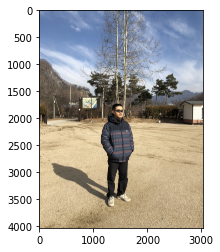

person image size:  (4032, 3024, 3)


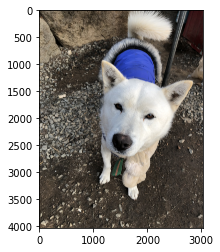

dog image size:  (4032, 3024, 3)


In [2]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
img_path_person = os.getenv('HOME')+'/aiffel/workplace/exploration/ex05/images/person.jpg'  
img_orig_person = cv2.imread(img_path_person)

img_path_dog = os.getenv('HOME')+'/aiffel/workplace/exploration/ex05/images/dog.jpg'  
img_orig_dog = cv2.imread(img_path_dog)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig_person, cv2.COLOR_BGR2RGB))
plt.show()
print('person image size: ',img_orig_person.shape)

plt.imshow(cv2.cvtColor(img_orig_dog, cv2.COLOR_BGR2RGB))
plt.show()
print('dog image size: ',img_orig_dog.shape)

### 2) 모델 불러오기: DeepLab 사전학습 모델

In [3]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')


####이미 다운로드해서 생략
# PixelLib가 제공하는 모델의 url입니다
#model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
# 다운로드를 시작합니다
#urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

In [4]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

### 3) 세그멘테이션 따기

In [5]:
# segmentAsPascalvoc()함수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용
segvalues_person, output_person = model.segmentAsPascalvoc(img_path_person)
segvalues_dog, output_dog = model.segmentAsPascalvoc(img_path_dog)

In [6]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

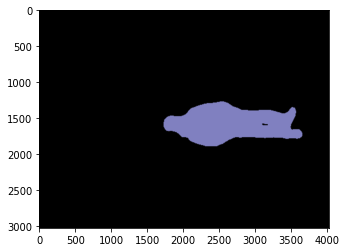

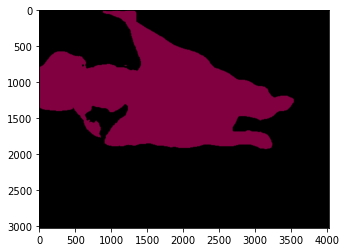

In [7]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output_person)
plt.show()

plt.imshow(output_dog)
plt.show()

In [8]:
segvalues_person # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력

# person
for class_id in segvalues_person['class_ids']:
    print(LABEL_NAMES[class_id])
print('-'*10)
    
# dog
for class_id in segvalues_dog['class_ids']:
    print(LABEL_NAMES[class_id])
print('-'*10)

background
person
----------
background
dog
----------


In [10]:
#20개 레이블 별 컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

person colormap:  [192 128 128]


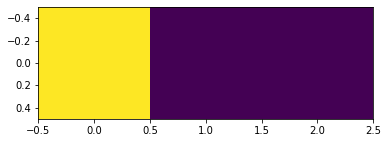

In [11]:
plt.imshow(np.array([colormap[15]]))
print('person colormap: ', colormap[15]) #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

dog colormap:  [ 64   0 128]


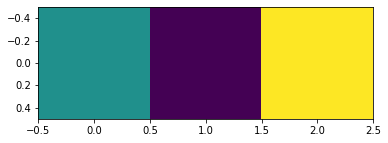

In [12]:
plt.imshow(np.array([colormap[12]]))
print('dog colormap: ', colormap[12]) #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 12번째인 개)

In [13]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
seg_color_person = (128,128,192)
seg_color_dog = (128,0,64)

(3024, 4032)


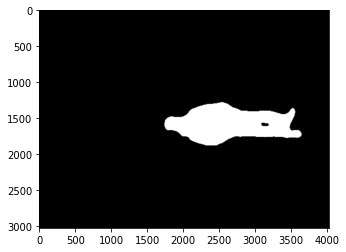

In [14]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map_person = np.all(output_person==seg_color_person, axis=-1) 
print(seg_map_person.shape) 
plt.imshow(seg_map_person, cmap='gray')
plt.show()

KeysView(<matplotlib.cm._DeprecatedCmapDictWrapper object at 0x7f8cad849ee0>)
(3024, 4032)


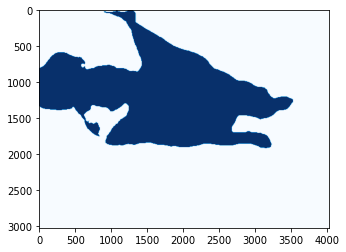

In [15]:
# cmap의 다른 옵션들
import matplotlib.cm
print(matplotlib.cm.cmap_d.keys())

# 개가 있는 위치를 제외하고 gray로 출력
seg_map_dog = np.all(output_dog==seg_color_dog, axis=-1) 
print(seg_map_dog.shape) 
plt.imshow(seg_map_dog, cmap='Blues')
plt.show()

In [16]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


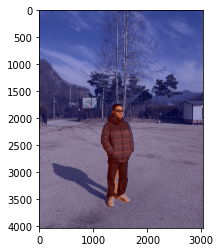

In [17]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show_person = img_orig_person.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask_person = seg_map_person.astype(np.uint8) * 255
img_mask_person = np.rot90(img_mask_person, 3) # 내 사진에서만 이유를 모르겠지만 사진이 회전된다. 이걸 고쳐주기

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask_person = cv2.applyColorMap(img_mask_person, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show_person = cv2.addWeighted(img_show_person, 0.6, color_mask_person, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_person, cv2.COLOR_BGR2RGB))
plt.show()

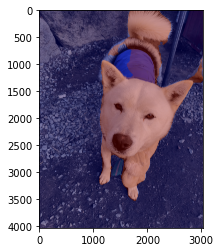

In [18]:
img_show_dog = img_orig_dog.copy()
img_mask_dog = seg_map_dog.astype(np.uint8) * 255
img_mask_dog = np.rot90(img_mask_dog, 3) # 내 사진에서만 이유를 모르겠지만 사진이 회전된다. 이걸 고쳐주기
color_mask_dog = cv2.applyColorMap(img_mask_dog, cv2.COLORMAP_JET)
img_show_dog = cv2.addWeighted(img_show_dog, 0.6, color_mask_dog, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show_dog, cv2.COLOR_BGR2RGB))
plt.show()

### 4) 블러 처리하기

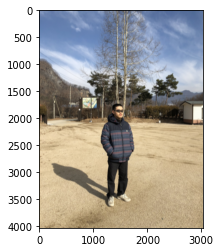

In [19]:
# (13,13)은 blurring kernel size를 뜻합니다
img_orig_blur_person = cv2.blur(img_orig_person, (20,20))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur_person, cv2.COLOR_BGR2RGB))
plt.show()

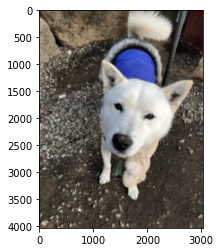

In [20]:
# (13,13)은 blurring kernel size를 뜻합니다
img_orig_blur_dog = cv2.blur(img_orig_dog, (25,25))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur_dog, cv2.COLOR_BGR2RGB))
plt.show()

### 5) 흐린 이미지에서 배경만 추출

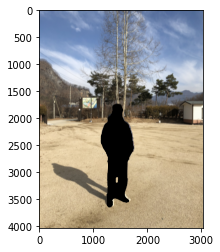

In [21]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color_person = cv2.cvtColor(img_mask_person, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask_person = cv2.bitwise_not(img_mask_color_person)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur_person = cv2.bitwise_and(img_orig_blur_person, img_bg_mask_person)
plt.imshow(cv2.cvtColor(img_bg_blur_person, cv2.COLOR_BGR2RGB))
plt.show()

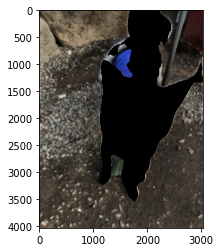

In [22]:
img_mask_color_dog = cv2.cvtColor(img_mask_dog, cv2.COLOR_GRAY2BGR)
img_bg_mask_dog = cv2.bitwise_not(img_mask_color_dog)
img_bg_blur_dog = cv2.bitwise_and(img_orig_blur_dog, img_bg_mask_dog)
plt.imshow(cv2.cvtColor(img_bg_blur_dog, cv2.COLOR_BGR2RGB))
plt.show()

### 6) 흐린 배경과 원본 마스크 이미지 합성

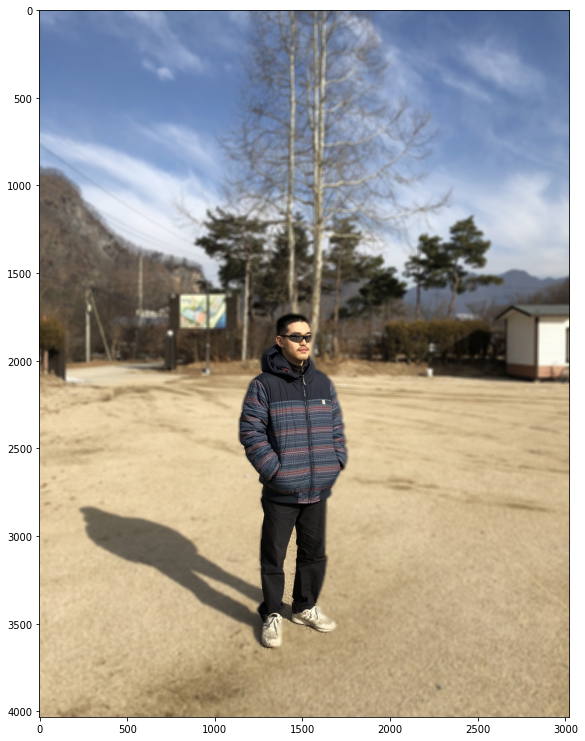

In [23]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat_person = np.where(img_mask_color_person==255, img_orig_person, img_bg_blur_person)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.figure(figsize=(10,13)) # 사진 사이즈 크게 출력
plt.imshow(cv2.cvtColor(img_concat_person, cv2.COLOR_BGR2RGB))
plt.show()

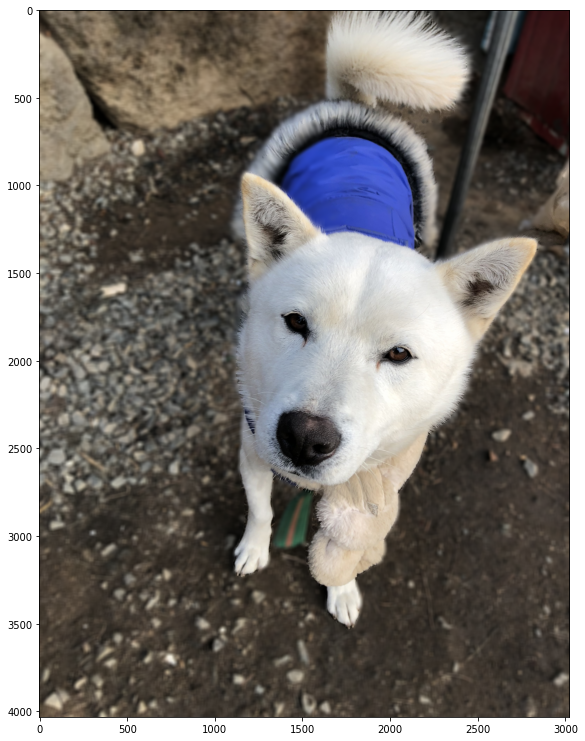

In [24]:
img_concat_dog = np.where(img_mask_color_dog==255, img_orig_dog, img_bg_blur_dog)
plt.figure(figsize=(10,13))
plt.imshow(cv2.cvtColor(img_concat_dog, cv2.COLOR_BGR2RGB))
plt.show()

### 추가) 크로마키사진 효과 적용

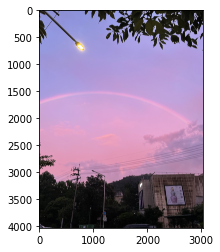

background image size:  (4032, 3024, 3)


In [25]:
# 배경 이미지 불러오기
img_path_bg = os.getenv('HOME')+'/aiffel/workplace/exploration/ex05/images/background.jpg'  
img_orig_bg = cv2.imread(img_path_bg)

plt.imshow(cv2.cvtColor(img_orig_bg, cv2.COLOR_BGR2RGB))
plt.show()
print('background image size: ',img_orig_bg.shape)

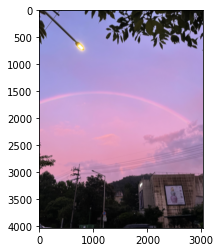

In [26]:
# (옵션) 이미지 블러 처리 
img_orig_blur_bg = cv2.blur(img_orig_bg, (20,20))
plt.imshow(cv2.cvtColor(img_orig_blur_bg, cv2.COLOR_BGR2RGB))
plt.show()

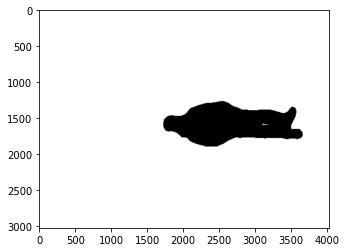

In [32]:
#
seg_color_bg = (0,0,0)
seg_map_bg = np.all(output_person==seg_color_bg, axis=-1)
plt.imshow(seg_map_bg, cmap='gray')
plt.show()

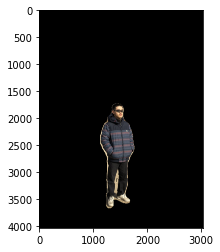

In [41]:
img_show_bg = img_orig_bg.copy()
img_mask_bg = seg_map_bg.astype(np.uint8) * 255
img_mask_bg = np.rot90(img_mask_bg, 3) # 내 사진에서만 이유를 모르겠지만 사진이 회전된다. 이걸 고쳐주기

img_mask_color_bg = cv2.cvtColor(img_mask_bg, cv2.COLOR_GRAY2BGR)
img_bg_mask_bg = cv2.bitwise_not(img_mask_color_bg)

img_person_only = cv2.bitwise_and(img_orig_person, img_bg_mask_bg)
plt.imshow(cv2.cvtColor(img_person_only, cv2.COLOR_BGR2RGB))
plt.show()

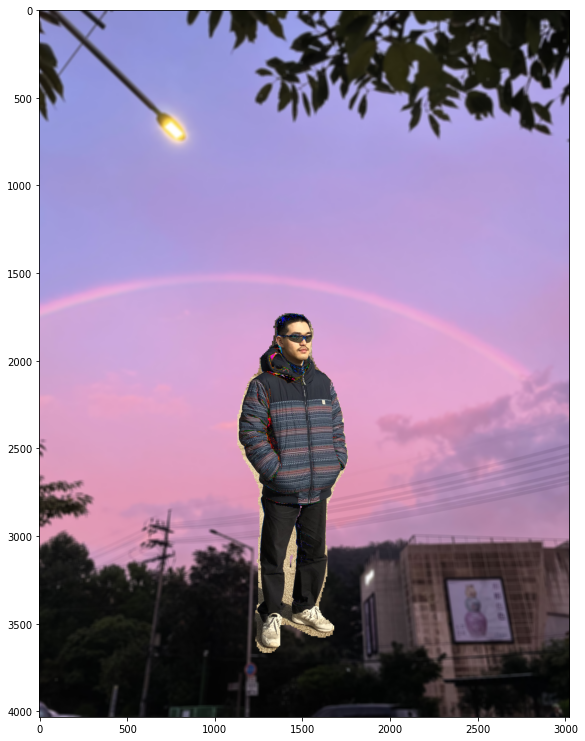

In [43]:
img_concat_bg_person = np.where(img_person_only==0, img_orig_blur_bg, img_person_only)
plt.figure(figsize=(10,13))
plt.imshow(cv2.cvtColor(img_concat_bg_person, cv2.COLOR_BGR2RGB))
plt.show()

### 보너스: 함수 만들기

In [ ]:
def image_segment(model, img_path, ):
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id])

## 2. 사진에서 문제점 찾기
아주 간단히 멋진 카메라 앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금 같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

생각해 볼 만한 주제를 아래에 몇 가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

#### 세그멘테이션의 한계
Semantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

#### 피사계 심도 이해하기
우선 피사계심도의 개념부터 명확히 이해해 봅시다.
- [아웃포커싱 하는 법](https://m.blog.naver.com/typs6301/222172333739)
- [얕은 피사계 심도 촬영의 이해](https://www.adobe.com/kr/creativecloud/photography/discover/shallow-depth-of-field.html)

#### 아웃포커싱 하는 법
얕은 피사계 심도 촬영의 이해
3D Camera 활용하기
이미지를 2D 방식으로 받아들이는 한계를 넘어 3D로 인식하려는 시도는 꽤 오래전부터 계속되어 왔습니다. 기술도 이제는 상당한 수준에 이르렀는데요. 크게는 스테레오 비전, ToF 방식 등이 자주 사용됩니다. 하드웨어 이미지 센서를 통한 3D 이미징 기술이 많이 발전되었는데요. 아래 참고 자료를 통해 최신 기술을 살펴봐도 좋습니다.

- [3D 이미지센서](https://news.skhynix.co.kr/post/next-gen-3d)

#### 소프트웨어 기술 활용하기
하드웨어 개발과 생산에는 비용이 많이 들기 때문에 제한된 하드웨어를 이용하면서 소프트웨어로 그 한계를 극복하려는 노력도 많습니다. 구글의 struct2Depth가 대표적인 예일 것 같습니다.

- [Unsupervised Learning of Depth and Ego-Motion: A Structured Approach](https://sites.google.com/view/struct2depth)

#### 다른 기술과 융합해 보기
구글 pixel4에는 IR(적외선) 카메라가 달려있는데요. 물체의 온도를 측정하는 IR 카메라와 3D 이미지는 크게 관련이 없을 것 같지만, 이를 통해 보다 멋진 3d depth sensing이 가능하다는군요.

- [uDepth: Real-time 3D Depth Sensing on the Pixel 4](https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html)



## 내 사진 문제점
- 한 object 내 같은 색상도 segmentation을 다르게 처리한다. 색상기반의 알고리즘이 아닌거 같다.
- object의 경계선을 제대로 파악 못하고 살짝 여유있게 segment를 잡는다.
- segmentation의 경계부분이 매끄럽지 못하다.

# 3. 문제점 개선 방안
- 다른 알고리즘: 여러 세그멘테이션 알고리즘을 써보고 내 사진에 제일 적합한 알고리즘을 선택한다.
- 앙상블: 다른 세그멘테이션 모델을 결합하여 앙상블을 구성합니다. 여러 모델의 예측을 평균화하거나 결합하여 더 강력한 세그멘테이션 결과를 얻을 수 있을 것 같습니다.
- 사전 처리 및 데이터 정제: 입력 이미지를 사전 처리하여 세그멘테이션 결과를 개선할 수 있을거 같습니다. 이미지 크기 조정, 밝기 및 콘트라스트 조정 등의 기술을 사용하여 모델에 더 나은 입력을 제공해볼 수 있습니다.
- 후처리 및 후프로세싱: 이미지 후처리 기술을 사용하여 세그멘테이션 결과를 개선할 수 있습니다. 예를 들어, 미디언 필터, 가우시안 필터, 모폴로지 연산 등을 사용하여 경계부분의 불연속한 영역을 부드럽게 만들 수 있습니다.

# 4. 회고
computer vision의 하위분야인 segementation에 대한 알고리즘과 그 적용 방법에 대해서 배울 수 있어 유익했다. DeepLabV1~V3+의 알고리즘 동작 방식을 제대로 이해하고 싶었지만 다음 기회에.. 크로마키효과를 내기 위해서 person이 아닌 background를 추출하는 방식이 유효했다. 이미지에 mask를 씌우면 원본 이미지가 시계방향으로 90도 회전하는 문제가 있었다. 원인은 모르겠지만, `np.rot90(image,3)`을 써서 해결했다. 원본이미지 메타데이터에 rotate관련 인자가 있는걸로 보이는데 mask를 씌우면서 그게 없어져서 나타난 현상으로 추측한다. [이 문서](https://exiftool.org/TagNames/EXIF.html)에서 orientation 파트 참고